## Lesson 5: Building Reproducible Workflows in ArcGIS Pro

### ArcGIS Notebooks

Over the course of this workshop, we have been building the foundations of a reproducible ArcGIS Notebook. We've taken efforts to automate our analysis by using Arcpy, standardized our working environment, and then documented and discussed our results in ArcGIS Notebooks. These steps were performed over the duration of the workshop, but they can be summarized and explored in complete detail below:

#### Setup Script

In [1]:
import os
import arcpy
arcpy.env.overwriteOutput = True
arcpy.env.addOutputsToMap = False

WORKSPACE = arcpy.env.workspace
YEARS = ['2019', '2020']
RASTER_PREFIX = 'Kangaroo_Island'
MASK = 'Kangaroo_Island'

for year in YEARS:
    MOSAIC_DATASET_NAME = '{}_{}'.format(RASTER_PREFIX, year)
    MOSAIC_DATASET_PATH = os.path.join(WORKSPACE, MOSAIC_DATASET_NAME)
    
    print("Creating {0} Mosaic Dataset @ {1}".format(MOSAIC_DATASET_NAME, MOSAIC_DATASET_PATH))

    INPUT_RASTER_A = os.path.join(WORKSPACE, MOSAIC_DATASET_NAME + 'A')
    INPUT_RASTER_B = os.path.join(WORKSPACE, MOSAIC_DATASET_NAME + 'B') 
    
    arcpy.management.CreateMosaicDataset(
        in_workspace=WORKSPACE,
        in_mosaicdataset_name=MOSAIC_DATASET_NAME,
        coordinate_system='PROJCS["WGS_1984_UTM_Zone_53S",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000.0],PARAMETER["False_Northing",10000000.0],PARAMETER["Central_Meridian",135.0],PARAMETER["Scale_Factor",0.9996],PARAMETER["Latitude_Of_Origin",0.0],UNIT["Meter",1.0]]',
        num_bands=None,
        pixel_type="",
        product_definition="NONE",
        product_band_definitions=None
    )
    
    print("Adding Rasters to {0} Mosaic Dataset".format(MOSAIC_DATASET_NAME))
    
    arcpy.management.AddRastersToMosaicDataset(
        in_mosaic_dataset=MOSAIC_DATASET_NAME,
        raster_type="Raster Dataset",
        input_path=r"'{0}';'{1}'".format(INPUT_RASTER_A, INPUT_RASTER_B),
        update_cellsize_ranges="UPDATE_CELL_SIZES",
        update_boundary="UPDATE_BOUNDARY",
        update_overviews="NO_OVERVIEWS",
        maximum_pyramid_levels=None,
        maximum_cell_size=0,
        minimum_dimension=1500,
        spatial_reference=None,
        filter="",
        sub_folder="SUBFOLDERS",
        duplicate_items_action="ALLOW_DUPLICATES",
        build_pyramids="BUILD_PYRAMIDS",
        calculate_statistics="CALCULATE_STATISTICS",
        build_thumbnails="NO_THUMBNAILS",
        operation_description="",
        force_spatial_reference="NO_FORCE_SPATIAL_REFERENCE",
        estimate_statistics="ESTIMATE_STATISTICS",
        aux_inputs=None,
        enable_pixel_cache="NO_PIXEL_CACHE",
    )
    
    print("Masking {0} Feature Layer to {1} Mosaic Dataset".format(MASK, MOSAIC_DATASET_NAME))
    
    with arcpy.EnvManager(scratchWorkspace=WORKSPACE):
        masked_raster = arcpy.sa.ExtractByMask(
            in_raster=MOSAIC_DATASET_NAME,
            in_mask_data=MASK,
            extraction_area="INSIDE",
            analysis_extent='637977.776913391 6003103.86212958 784131.326170237 6063647.6465892 PROJCS["WGS_1984_UTM_Zone_53S",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000.0],PARAMETER["False_Northing",10000000.0],PARAMETER["Central_Meridian",135.0],PARAMETER["Scale_Factor",0.9996],PARAMETER["Latitude_Of_Origin",0.0],UNIT["Meter",1.0]]'
        )
    masked_raster.save(MOSAIC_DATASET_NAME + "_Masked")
    print("Successfully Created {0}".format(MOSAIC_DATASET_NAME + "_Masked"))
    print()
print("Setup Completed.")

Creating Kangaroo_Island_2019 Mosaic Dataset @ C:\Users\col12422\Documents\ArcGIS\Projects\Arcpy Workshop\Arcpy Workshop.gdb\Kangaroo_Island_2019
Adding Rasters to Kangaroo_Island_2019 Mosaic Dataset
Masking Kangaroo_Island Feature Layer to Kangaroo_Island_2019 Mosaic Dataset
Successfully Created Kangaroo_Island_2019_Masked

Creating Kangaroo_Island_2020 Mosaic Dataset @ C:\Users\col12422\Documents\ArcGIS\Projects\Arcpy Workshop\Arcpy Workshop.gdb\Kangaroo_Island_2020
Adding Rasters to Kangaroo_Island_2020 Mosaic Dataset
Masking Kangaroo_Island Feature Layer to Kangaroo_Island_2020 Mosaic Dataset
Successfully Created Kangaroo_Island_2020_Masked

Setup Completed.


#### Analysis

In [2]:
import os
import arcpy
arcpy.env.addOutputsToMap = True

In [3]:
def nbr(nir, swir):
    nbr_index = numpy.nan_to_num(numpy.divide((nir - swir), (nir + swir)))
    return nbr_index

In [4]:
def delta_nbr(nbr_base, nbr_post):
    d_nbr = numpy.subtract(nbr_base, nbr_post)
    return d_nbr

In [5]:
def kangaroo_nbr_analysis(raster_base, raster_post):
    nir_base = arcpy.RasterToNumPyArray(os.path.join(raster_base, "Band_8"), nodata_to_value=0).astype(float)
    swir_base =  arcpy.RasterToNumPyArray(os.path.join(raster_base, "Band_10"), nodata_to_value=0).astype(float)

    nir_post = arcpy.RasterToNumPyArray(os.path.join(raster_post, "Band_8"), nodata_to_value=0).astype(float)
    swir_post = arcpy.RasterToNumPyArray(os.path.join(raster_post, "Band_10"), nodata_to_value=0).astype(float)

    return delta_nbr(nbr(nir_base, swir_base), nbr(nir_post, swir_post))

#### Execution

In [6]:
kangaroo_2019 = arcpy.Raster("Kangaroo_Island_2019_Masked")
lower_left = arcpy.Point(kangaroo_2019.extent.XMin,kangaroo_2019.extent.YMin)
cell_size = kangaroo_2019.meanCellWidth

kangaroo_delta_nbr = kangaroo_nbr_analysis("Kangaroo_Island_2019_Masked", "Kangaroo_Island_2020_Masked")

Delta_NBR = arcpy.NumPyArrayToRaster(kangaroo_delta_nbr, lower_left, cell_size, value_to_nodata = 0)

[3]:2: RuntimeWarning: invalid value encountered in true_divide


#### Discussion

The Normalized Burn Ratio (**NBR**) is an index that uses the differences in the way healthy green vegetation and burnt vegetation reflect light to find burnt area. The equation is defined below:
$$NBR =\dfrac{nir-swir}{nir+swir}$$ <br>
We'll leverage the NumPy library to perform matrix artithmetic to calculate **NBR** for Kangaroo Island. <br><br>
We can create a function to perform the subtraction, addition, and division of our arrays as seen here:

$$ 
NBR_{2019} =
\frac{\begin{bmatrix}
0.43 & -1.34 \\
1.33 & 0.59 & \cdots
\end{bmatrix}
-
\begin{bmatrix}
-3.21 & 0.12 \\
1.33 & -4.32 & \cdots
\end{bmatrix}}{\begin{bmatrix}
0.43 & -1.34 \\
1.33 & 0.59 & \cdots
\end{bmatrix}
+
\begin{bmatrix}
-3.21 & 0.12 \\
1.33 & -4.32 & \cdots
\end{bmatrix}}
$$

$$ 
NBR_{2020} =
\frac{\begin{bmatrix}
3.53 & 0.32 \\
4.55 & 3.76 & \cdots
\end{bmatrix}
-
\begin{bmatrix}
6.31 & 10.99 \\
44.73 & 8.39 & \cdots
\end{bmatrix}}{\begin{bmatrix}
3.53 & 0.32 \\
4.55 & 3.76 & \cdots
\end{bmatrix}
+
\begin{bmatrix}
6.31 & 10.99 \\
44.73 & 8.39 & \cdots
\end{bmatrix}}
$$

In [ ]:
def nbr(nir, swir):
    nbr_index = numpy.nan_to_num(numpy.divide((nir - swir), (nir + swir)))
    return nbr_index

With a function for calculating the **NBR** for our arrays, we now have a normalized way of comparing values from one year to another. We can find the delta from **NBR<sub>2019</sub>**, before the fire, to **NBR<sub>2020</sub>**, after the fire, to get a comparison of the wildfire damage! We'll use NumPy to subtract the **NBR<sub>2019</sub>** array from the **NBR<sub>2020</sub>** array to get our **NBR<sub>&Delta;</sub>** array.

$$ 
NBR_{\Delta} = NBR_{2019} - NBR_{2020}
$$

In [ ]:
def delta_nbr(nbr_base, nbr_post):
    d_nbr = numpy.subtract(nbr_base, nbr_post)
    return d_nbr

With the ```nbr``` and ```delta_nbr``` functions defined, it's now possible to repeatably calculate the **NBR<sub>&Delta;</sub>** for any given arrays. But to make our functions easy to use, let's also write out another function that accepts the base and post-fire rasters for our analysis.

In [ ]:
def kangaroo_fire_analysis(raster_base, raster_post):
    nir_base = arcpy.RasterToNumPyArray(os.path.join(raster_base, "Band_8"), nodata_to_value=0).astype(float)
    swir_base =  arcpy.RasterToNumPyArray(os.path.join(raster_base, "Band_10"), nodata_to_value=0).astype(float)
    
    nir_post = arcpy.RasterToNumPyArray(os.path.join(raster_post, "Band_8"), nodata_to_value=0).astype(float)
    swir_post = arcpy.RasterToNumPyArray(os.path.join(raster_post, "Band_10"), nodata_to_value=0).astype(float)
    
    return delta_nbr(nbr(nir_base, swir_base), nbr(nir_post, swir_post))

### ArcGIS ModelBuilder

ArcGIS ModelBuilder is another way to create reproducible workflows in ArcGIS Pro, without the need of writing any code. It's a visual coding tool used for stringing together geoprocessing tools. And when configured properly with parameters, it can be saved as a custom geoprocessing tool and used in ArcGIS Pro's GUI. We'll build a ModelBuilder that automates the image processing section of our previous workflow:

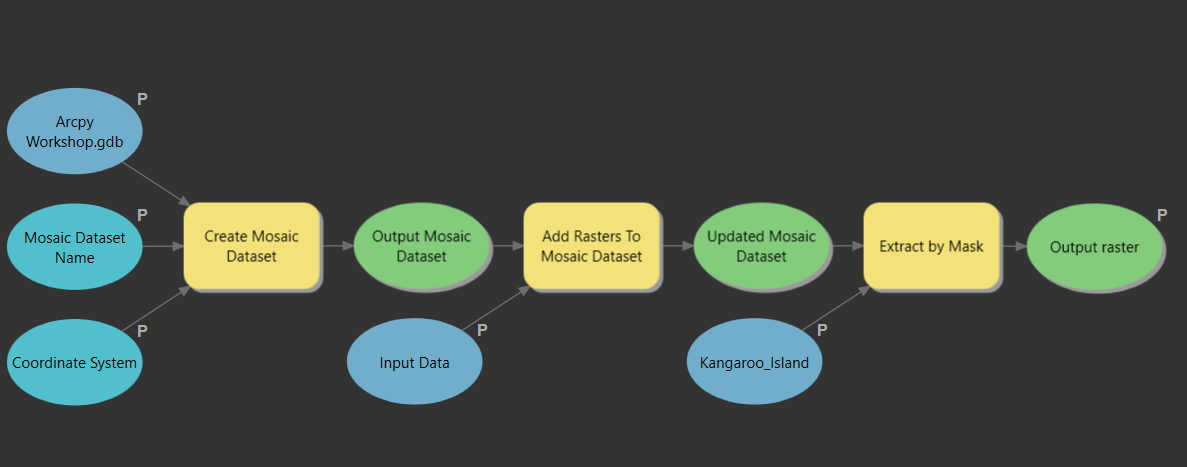

Open ModelBuilder in ArcGIS Pro and replicate the model above.

1. Drag & Drop the Create Mosaic Dataset tool into the ModelBuilder pane. <br>
- Right click the tool, then navigate to Create Variable > From Parameter > Output Location
    - Double Click the variable and set the location to the arcpy_workshop.gdb file geodatabase
    - Right Click the variable and select Parameter
- Right click the tool, then navigate to Create Variable > From Parameter > Mosaic Dataset Name
    - Double Click the variable and set the name to MB_Mosaic
    - Right Click the variable and select Parameter
- Right click the tool, then navigate to Create Variable > From Parameter > Coordinate System
    - Double Click the variable and set the coordinate system to WGS_1984_UTM_Zone_53S
    - Right Click the variable and select Parameter

2. Drag & Drop the Add Raster to Mosaic Dataset tool into the ModelBuilder pane. <br>
- Right click the tool, then navigate to Create Variable > From Parameter > Input Data
    - Double Click the variable and set the input data to the Kangaroo_Island_2019A & Kangaroo_Island_2019B rasters located in the Arcpy Workshop.gdb file geodatabase
    - Right Click the variable and select Parameter
- Drag the Output Mosaic Dataset to the Add Rasters to Mosaic Dataset to connect the output to the input. Set it as the Mosaic Dataset.

3. Drag & Drop the Extract by Mask tool into the ModelBuilder pane. <br>
- Right click the tool, then navigate to Create Variable > From Parameter > Input raster or feature mask data
    - Double Click the variable and set the input data to the Kangaroo_Island feature layer located in the arcpy_workshop.gdb file geodatabase
    - Right Click the variable and select Parameter
- Drag the Updated Mosaic Dataset output to the Extract by Mask tool to connect the output to the input. Set it as the Input Raster.
- Right Click the Output raster variable and select Parameter

Validate, Run, & Save the tool as ```ModelBuilder_Mask```

Now open the tool from the Catalog Pane in ArcGIS Pro by navigating to Toolboxes > arcpy_workshop.atbx > ModelBuilder_Mask. Double click to open the tool as a geoprocessing tool.